## Introduction

I'm looking to buy a house in the near future. I'm pretty risk averse, so even though I know that in theory a variable rate mortgage should be better for me financially, I was willing to take a fixed rate mortgage in order to have more certainty. In discussion with a mortgage broker it was suggested that I could get the best of both worlds by taking out a capped variable mortgage and increasing my payment amount to what I would have paid under a fixed rate. In theory this gives me a hedge in that my payments are capped, and as long as my variable rate is below the fixed rate I'm making extra payments against my principle compared to what I'd be doing with a fixed rate. Let's see what that looks like under some different scenarios using python. Some of these calculations I already implemented in my [rent or own calculator](https://github.com/ianepreston/rentorown/blob/master/src/rentorown/house.py) but the scenarios I'm working on are different enough here that I'm only going to use that as a reference rather than importing any of the code.

## Get some data

To do any scenario planning it will be helpful to have some historical data on the relevant interest rates. Specifically I want to know 5 year fixed mortgage rates, and the big bank prime rate, as that forms the basis of variable rate mortgages. At the time of this writing RBC is offering variable mortgages at "RBC Prime Rate - 0.750%" but they're also offering a "special rate" of 3.34% compared to their posted rate of 4.79% for 5 year fixed. The delta there is 1.45%. Their posted variable rate is just their posted prime. I'm less interested in the exact rates than I am the delta. It looks like right now the delta of their offered rates between fixed and closed (3.34 - 1.95 = 1.39) is less than their posted fixed and closed rate (4.79 - 2.70 = 2.09). Because the data set I can work with only has posted rates and I have no way of estimating the "true" delta in historical periods I'll use it as the basis for this analysis. However, it will be important to remember that at least in this current low interest rate environment there's less of a gap between fixed and variable rates than my data will suggest. Depending on how close these scenarios play out I can re-run them by adding 2.09 - 1.39 = 0.7 onto my prime rate to simulate that narrower gap.

In [1]:
from collections import defaultdict
import pandas as pd
import requests

First we grab some historical rate data in JSON from the Bank of Canada website. I tried to grab it as a CSV but it's terribly formatted, so we'll go with this and clean it up.

In [2]:
rates_json = requests.get("https://www.bankofcanada.ca/valet/observations/group/chartered_bank_interest/json").json()

Next I have to clean it up into a dataframe for analysis.

In [3]:
renamer = {k: f"{v['description']} {v['label']}".strip() for k, v in rates_json["seriesDetail"].items()}

In [4]:
base_df = (
    pd.DataFrame(rates_json["observations"])
    # convert date series from string to datetime
    .assign(d=lambda df: pd.to_datetime(df["d"]))
    .set_index("d")
    # Get the actual rate value out of the dictionary it's in
    .applymap(lambda x: float(x["v"]), na_action='ignore')
    .rename(columns=renamer)
)

Let's take a quick look at it to make sure it's sensible.

In [5]:
base_df.tail()

,Non-Chequable Savings Deposits,5-year personal fixed term,Prime rate,Conventional mortgage 5-year,Conventional mortgage 1-year,Conventional mortgage 3-year,Guaranteed investment certificates 5-year,Guaranteed investment certificates 1-year,Guaranteed investment certificates 3-year,"Daily Interest Savings (balances over $100,000)"
d,,,,,,,,,,
2022-02-16,0.01,1.15,2.45,4.79,2.79,3.49,1.65,0.60,1.25,0.01
2022-02-23,0.01,1.45,2.45,4.79,2.79,3.49,1.75,0.60,1.35,0.01
2022-03-02,0.01,1.45,2.45,4.79,2.79,3.49,1.75,0.60,1.35,0.01
2022-03-09,0.01,1.55,2.70,4.79,2.79,3.49,1.85,0.65,1.28,0.01
2022-03-16,0.01,1.55,2.70,4.79,2.79,3.49,1.85,0.78,1.30,0.01


That looks good to me. I'm just going to shrink it down to the just the columns I care about, resample it down to monthly frequency, and give them easier to work with names.

In [6]:
df = (
    base_df
    .rename(columns={"Prime rate": "prime", "Conventional mortgage 5-year": "fiveyear"})
    .reindex(columns=["prime", "fiveyear"])
    # Most early dates don't have values for these series
    .dropna(how="all")
    .reset_index()
    # Group it to the first entry for each month
    .groupby(pd.Grouper(key="d", freq="M", convention="start"))
    .first()
    # Make it the start rather than end of the month to make date deltas easier
    .reset_index()
    .assign(d=lambda df: df["d"].dt.to_period('M').dt.to_timestamp())
    .set_index("d")
)
df.head()

,prime,fiveyear
d,,
1975-01-01,11.0,12.00
1975-02-01,9.5,11.50
1975-03-01,9.0,10.75
1975-04-01,9.0,10.50
1975-05-01,9.0,10.75


## Some quick exploration

Let's do some basic charting on this data just to get a sense of what we're working with.

In [7]:
# Would rather use altair but I have lots of data points and I'm not sure how using render server will play with my static site generator
import seaborn as sns
import matplotlib.pyplot as plt
# Make my charts a decent size
sns.set(rc = {'figure.figsize':(15,8)})

In [8]:
# Seaborn likes data in tidy format
cdf = df.melt(ignore_index=False).reset_index()

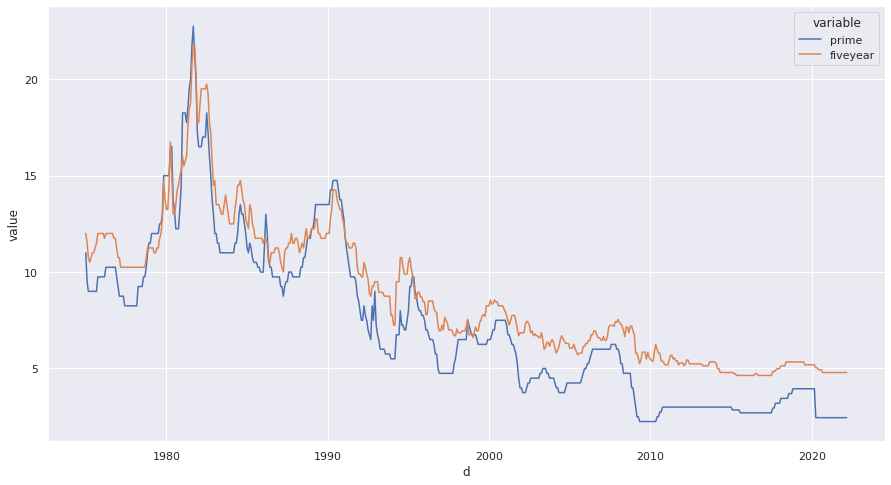

In [9]:
sns.lineplot(data=cdf, x="d", y="value", hue="variable");

Here's what prime vs 5 year mortgage rates have looked like for the last 50ish years. The variable rate tends to be below the fixed at any given point in time, but of course the variable rate can go up over your mortgage term while a fixed rate will stay fixed. Let's start the actual analysis.

## Check variable vs 5 year term

For any starting period I can compare a 5 year fixed rate to what the variable rate would have been over that same period and plot the delta between them. Let's see what that looks like:

In [10]:
# Get all the dates that have at least 5 years of history ahead of them
start_dates = list(df.index[:-60])

In [11]:
delta_dict = defaultdict(dict)
for start_date in start_dates:
    five_year_rate = df.loc[start_date, "fiveyear"]
    for delta in range(60):
        variable_rate = df.loc[start_date + pd.DateOffset(months=delta), "prime"]
        variable_delta = variable_rate - five_year_rate
        delta_dict[delta][start_date] = variable_delta
delta_df = pd.DataFrame(delta_dict).T
delta_df.head()

,1975-01-01,1975-02-01,1975-03-01,1975-04-01,1975-05-01,1975-06-01,1975-07-01,1975-08-01,1975-09-01,1975-10-01,...,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01
0,-1.0,-2.0,-1.75,-1.5,-1.75,-2.00,-2.00,-2.25,-2.50,-2.25,...,-1.94,-2.04,-2.04,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94
1,-2.5,-2.5,-1.75,-1.5,-1.75,-2.00,-2.00,-2.25,-1.75,-2.25,...,-1.94,-2.04,-2.04,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94
2,-3.0,-2.5,-1.75,-1.5,-1.75,-2.00,-2.00,-1.50,-1.75,-2.25,...,-1.94,-2.04,-2.04,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94
3,-3.0,-2.5,-1.75,-1.5,-1.75,-2.00,-1.25,-1.50,-1.75,-2.25,...,-1.94,-2.04,-2.04,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94
4,-3.0,-2.5,-1.75,-1.5,-1.75,-1.25,-1.25,-1.50,-1.75,-2.25,...,-1.94,-2.04,-2.04,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94,-1.94


In [12]:
delta_cdf = (
    delta_df
    .melt(ignore_index=False)
    .reset_index()
    # change from a date to a count of months since the first period
    # makes it easier to add in a colour scale and get a sense of time periods.
    .assign(variable=lambda df: (df["variable"] - df["variable"].min()).dt.days)
    .rename(columns={"index": "period", "variable": "start date delta", "value": "variable_delta"})
)

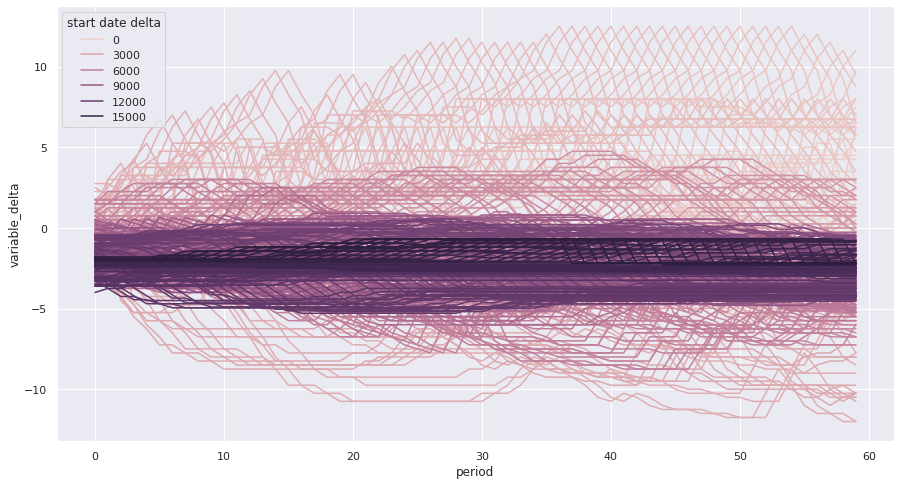

In [13]:
sns.lineplot(data=delta_cdf, x="period", y="variable_delta", hue="start date delta");

This chart shows the change in the delta between a fixed rate mortgage and the variable rate over a 5 year period. Each line represents a potential start month, with the delta between fixed and variable on the y axis and how many months into the 5 year term that mortgage is on the x axis. The colour corresponds to the number of days after Jan 1 1970 the scenario starts (I just needed a nice linear series to get the colour coding).

That's way too noisy to make a ton of sense of, but it shows that variable rates can be quite a lot higher or lower than the 5 year fixed. Most of the crazy outliers are lighter in colour, which corresponds to earlier points in history and given the wildly volatile interest rates we saw in the previous chart that seems reasonable. Eyeballing it it definitely looks like the majority of series are below the 0 line throughout the 5 year period.

One could make the argument that including the 1980s is unfair given the crazy stagflation and associated high interest rates used to combat them. If you think more recent history is a better guide we can look at just the scenarios starting since the year 2000:

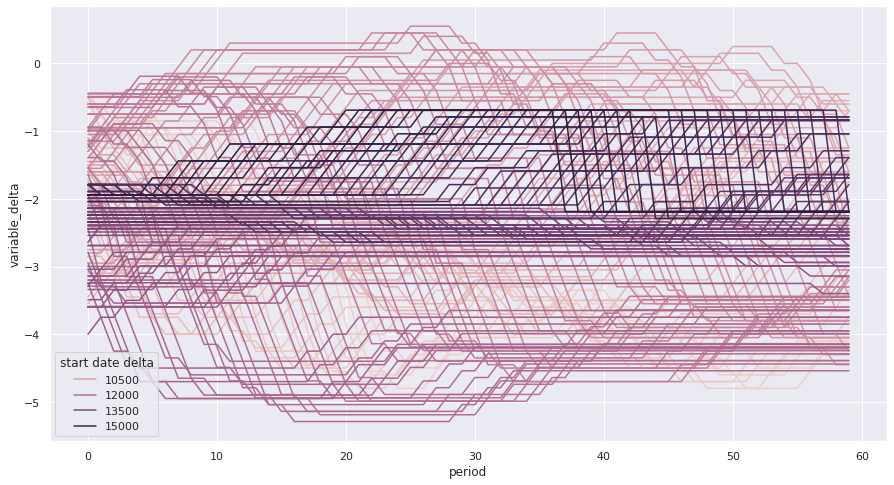

In [14]:
subset_cdf = delta_cdf.loc[lambda df: df["start date delta"] >= 25 * 365]
sns.lineplot(data=subset_cdf, x="period", y="variable_delta", hue="start date delta");

So since 2000 it looks like your variable rate has almost never gone above the five year fixed rate. Again, recall that the actual fixed or variable rate you'd get at any of these points is not perfectly correlated with the posted rates I'm using, but it's still a good indicator. Personally since I'm risk averse and we are currently looking at higher inflation than there's been for 30 years I'm inclined to use the longer term scenarios, but it was an interesting exercise to see what more recent history looks like.

Now, even though these charts are kind of pretty, they're not very informative, there's too much going on. What I can do instead is summarize the distribution of those lines. So for any point in the mortgage term I can show the mean delta, or the median, or any other quantile. Let's take a look at that:

In [15]:
full_series = [delta_df.mean(axis="columns").rename("mean")]
for q in [0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95]:
    full_series.append(delta_df.quantile(q, axis="columns").rename(f"q{q}"))
full_distributions = pd.concat(full_series, axis="columns")

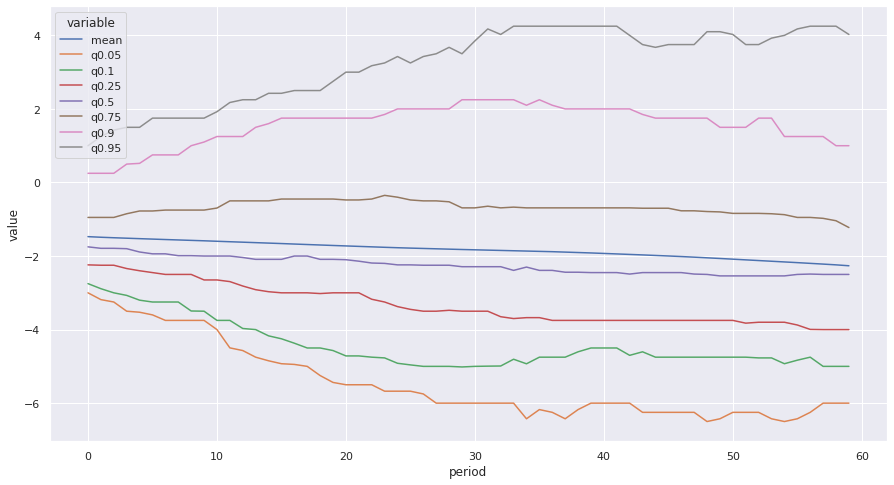

In [16]:
fdist_cdf = (
    full_distributions
    .melt(ignore_index=False)
    .reset_index()
    .rename(columns={"index": "period"})
)
sns.lineplot(data=fdist_cdf, x="period", y="value", hue="variable");

So over the whole observation period the mean gap between fixed and variable rate tends to trend downward, which makes sense given interest rates were declining over most of the observed period. At least 3/4 of the time they stayed below the fixed rate for the entire period, but when we look at the 90th percentile and above they were over the fixed rate throughout the period (this is not saying any one series was consistently that high above throughout the 5 year period, just that at least 10% of them were that much above it at that point.) Let's try it again, just focusing on since 2000.

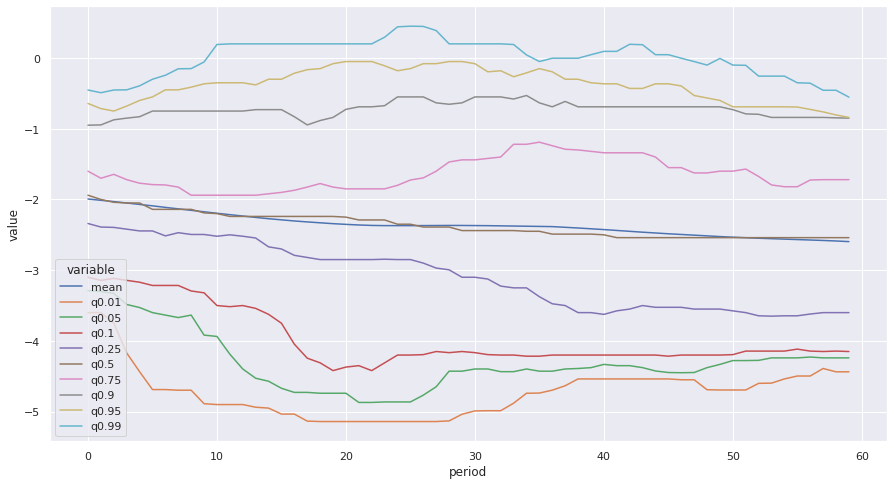

In [17]:
rdelta_df = delta_df.T.loc["2000":].T
full_series = [rdelta_df.mean(axis="columns").rename("mean")]
for q in [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    full_series.append(rdelta_df.quantile(q, axis="columns").rename(f"q{q}"))
full_distributions = pd.concat(full_series, axis="columns")
fdist_cdf = (
    full_distributions
    .melt(ignore_index=False)
    .reset_index()
    .rename(columns={"index": "period"})
)
sns.lineplot(data=fdist_cdf, x="period", y="value", hue="variable");

So in the more recent period I checked out some of the wider end of the tails. At the 99th percentile we do see a couple spots where it goes above 0, but not by much. Variable rates over the last 20 years have been a pretty sweet deal.

## Model out capped variable strategy

Looking at these trends, it definitely seems like going with the capped variable rate would be the way to go, but let's model it out a bit and see.
The first thing I need to do is write a class that can handle mortgage payments, including variable payments or a capped variable strategy. For that I can leverage some of the code I wrote for my rent or own calculator (with some tweaks).

In [18]:
import math
from collections import OrderedDict
import numpy_financial as npf
import numpy as np

In [19]:
class Mortgage:
    """Base mortgage class.
    Parameters
    ----------
    delta_series: pd.Series
        The series of rate deltas over the 5 year term. Can pass in a series of 0s to simulate a fixed rate mortgage
    capped_variable: bool
        Whether to use the capped variable or regular variable payment strategy
    principal: Int
        Value of the mortgage, default $400K to simulate a $500K purchase with 20% down
    amortize_years: int
        Amortization period of the mortgage (not term of mortgage), default to standard 25 for a new purchase
    fixed_rate: float
        fixed 5 year APR rate as posted online, will use AER for actual calculations, default to 4.79 since that's the latest value
        in the series at the time of this writing.
    """

    def __init__(self, delta_series: pd.Series, scenario_name: str, capped_variable: bool = True, principal: int=400_000 , amortize_years: int = 25, fixed_rate: float = 4.79) -> None:
        self.delta_series = delta_series
        # So I can label dataframes or other returned objects
        self.scenario_name = scenario_name
        self.capped_variable = capped_variable
        self.principal = principal
        self.amortize_years = amortize_years
        self.fixed_rate = fixed_rate
        # Have to do different compounding period for variable (monthly) vs fixed (semi annual)
        if delta_series.sum() == 0:
            self.fixed = True
        else:
            self.fixed = False
        self.fixed_pmt = self._calc_fixed_pmt()
    
    def periodic_rate(self, period: int) -> float:
        """Calculate the periodic interest rate from the posted APR.
        
        Parameters
        ----------
        period: int
            Which period in the term we're in (used to identify the variable rate delta)
        
        Returns
        -------
        float: periodic interest rate
        """
        apr = self.fixed_rate + self.delta_series[period]
        apr_dec = apr / 100
        if self.fixed:
            compounds = 2
        else:
            compounds = 12
        aer = (1 + (apr_dec / compounds)) ** compounds - 1
        return (1 + aer) ** (1 / 12) - 1

    def _calc_fixed_pmt(self) -> float:
        """Calculate what a fixed payment would be to compute capped variable payments."""
        apr_dec = self.fixed_rate / 100
        compounds = 2 
        aer = (1 + (apr_dec / compounds)) ** compounds - 1
        periodic_rate = (1 + aer) ** (1 / 12) - 1
        periods = self.amortize_years * 12
        return -round(npf.pmt(periodic_rate, periods, self.principal), 2)
        
    def _amortizegen(self):
        """Yield a dictionary of a payment period.
        
        Have to do it incrementally because additional payments can mean recomputing things after every period.
        
        Parameters
        ----------
        period: int
            Which period of the term we're in
        
        Yields
        ------
        Dict
            All the data for another period of mortgage paments
        """
        period = 0
        beg_balance = self.principal
        end_balance = self.principal
        # Careful here, have to control how often this is called outside the function
        while period < 60:
            periodic_rate = self.periodic_rate(period)
            amortization_left = (self.amortize_years * 12) - period
            interest = -npf.ipmt(rate=periodic_rate, per=1, nper=amortization_left, pv=beg_balance)
            if self.capped_variable:
                if interest >= self.fixed_pmt:
                    principal = 0
                else:
                    principal = self.fixed_pmt - interest
            else:
                principal = -npf.ppmt(rate=periodic_rate, per=1, nper=amortization_left, pv=beg_balance)
            total_pmt = interest + principal
            end_balance = beg_balance - principal
            yield OrderedDict(
                [
                    ("Period", period),
                    ("Begin_balance", beg_balance),
                    ("Payment", total_pmt),
                    ("Principal", principal),
                    ("Interest", interest),
                    ("End_balance", end_balance),
                ]
            )
            # increment the counter, balance and date
            period += 1
            beg_balance = end_balance

    def amortize(self) -> pd.DataFrame:
        """Show payments on the mortgage.
        
        Returns
        -------
        pd.DataFrame
            Dataframe of mortgage payments showing principal and interest contributions and amount outstanding
        """
        df = (
            pd.DataFrame(self._amortizegen())
            .set_index("Period")
        )
        return df
    
    def summarize(self) -> dict:
        """Summarize the 5 year term."""
        df = self.amortize()
        return {
            "scenario_name": self.scenario_name,
            "end_balance": df.iloc[-1]["End_balance"],
            "total_payments": df["Payment"].sum(),
            "average_payment": df["Payment"].mean(),
            "min_payment": df["Payment"].min(),
            "max_payment": df["Payment"].max(),
            "total_interest": df["Interest"].sum(),
            "total_principal": df["Principal"].sum(),
        }

    def pretty_summary(self) -> None:
        """Print out the summary in pretty format."""
        summary = self.summarize()
        result = f"""
            Scenario: {summary["scenario_name"]}
            Capped: {self.capped_variable}
            Total Payments: ${summary["total_payments"]:,.0f}
            Ending mortgage balance: ${summary["end_balance"]:,.0f}
            Total interest payments: ${summary["total_interest"]:,.0f}
            Total principal payments: ${summary["total_principal"]:,.0f}
            Average payment: ${summary["average_payment"]:,.0f}
            Minimum payment: ${summary["min_payment"]:,.0f}
            Maximum payment: ${summary["max_payment"]:,.0f}
        """
        print(result)

Let's look at the summary of a few of these scenarios

In [20]:
fixed_scenario = Mortgage(
    delta_series=np.zeros(60),
    scenario_name="fixed payments",
    capped_variable=False
)
fixed_summary = fixed_scenario.summarize()
fixed_scenario.pretty_summary() 


            Scenario: fixed payments
            Capped: False
            Total Payments: $136,730
            Ending mortgage balance: $352,851
            Total interest payments: $89,581
            Total principal payments: $47,149
            Average payment: $2,279
            Minimum payment: $2,279
            Maximum payment: $2,279
        


In [21]:
Mortgage(
    delta_series=delta_df["1975-01-01"],
    scenario_name="1975-01-01",
    capped_variable=False
).pretty_summary() 


            Scenario: 1975-01-01
            Capped: False
            Total Payments: $111,026
            Ending mortgage balance: $340,142
            Total interest payments: $51,168
            Total principal payments: $59,858
            Average payment: $1,850
            Minimum payment: $1,536
            Maximum payment: $2,801
        


In [22]:
Mortgage(
    delta_series=delta_df["1975-01-01"],
    scenario_name="1975-01-01 capped",
    capped_variable=True
).pretty_summary() 


            Scenario: 1975-01-01 capped
            Capped: True
            Total Payments: $136,730
            Ending mortgage balance: $311,809
            Total interest payments: $48,539
            Total principal payments: $88,191
            Average payment: $2,279
            Minimum payment: $2,279
            Maximum payment: $2,279
        


Before I run a bunch of scenarios from historical ones, let's plug in something derived from a forecast. [TD forecasts](https://economics.td.com/ca-long-term-forecast) the overnight rate for the BoC will end 2022 at 1.25% (it's 0.5% as I write this) and climb to 1.75% by the end of 2023 before leveling off for the remainder of the forecast period. Let's make a scenario where variable rates follow that same hike schedule 1:1

In [23]:
# Current delta based on "special" rates available on RBC site
start_delta = -1.39
delta_series = np.repeat(start_delta, 60)
# let's do 3 0.25 rate hikes over the next 9 months
for cut in [3, 6, 9]:
    delta_series[cut:] += 0.25
#Then we need two hikes in 2023
for cut in [12, 18]:
    delta_series[cut:] += 0.25

In [24]:
Mortgage(
    delta_series=delta_series,
    scenario_name="1.25% total hikes, capped",
    capped_variable=True
).pretty_summary() 


            Scenario: 1.25% total hikes, capped
            Capped: True
            Total Payments: $136,730
            Ending mortgage balance: $346,032
            Total interest payments: $82,762
            Total principal payments: $53,968
            Average payment: $2,279
            Minimum payment: $2,279
            Maximum payment: $2,279
        


In [25]:
Mortgage(
    delta_series=delta_series,
    scenario_name="1.25% total hikes, uncapped",
    capped_variable=False
).pretty_summary() 


            Scenario: 1.25% total hikes, uncapped
            Capped: False
            Total Payments: $132,412
            Ending mortgage balance: $351,139
            Total interest payments: $83,552
            Total principal payments: $48,861
            Average payment: $2,207
            Minimum payment: $1,981
            Maximum payment: $2,250
        


So in this scenario (which I'm definitely not saying will happen, but it's plausible) either of the variable strategies beat a fixed strategy since we never get up to the fixed rate. Between capped and full variable you make bigger payments and also pay less interest, so as long as those payments are manageable that seems like a pretty solid deal. Let's run this against a bunch of historical scenarios now.

First we'll look at the distribution of outcomes for the capped strategy based on historical rate delta development

In [26]:
capped_scenarios = pd.DataFrame([
    Mortgage(
        delta_series=delta_df[col],
        scenario_name="1975-01-01 capped",
        capped_variable=True
    ).summarize()
    for col in delta_df.columns
])

/home/ipreston/miniconda3/envs/mortgage/lib/python3.10/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in double_scalars
  (1 + rate*when)*(temp - 1)/rate)
/home/ipreston/miniconda3/envs/mortgage/lib/python3.10/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in double_scalars
  (1 + rate*when)*(temp - 1)/rate)


In [27]:
def plot_hist(data, col):
    g = sns.histplot(data=data,x=col, bins=50, stat="percent")
    plt.axvline(x=fixed_summary[col], color="red")
    return g

This chart shows the distribution of end balances (the amount still owing on the mortgage at the end of the 5 year term) using the capped variable strategy across all the historical scenarios we outlined above. The red vertical line is the equivalent point for going with a fixed rate. The vast majority of points show a lower ending balance, which is definitely good, although there is some tail risk of ending with a balance of up to about $50k more.

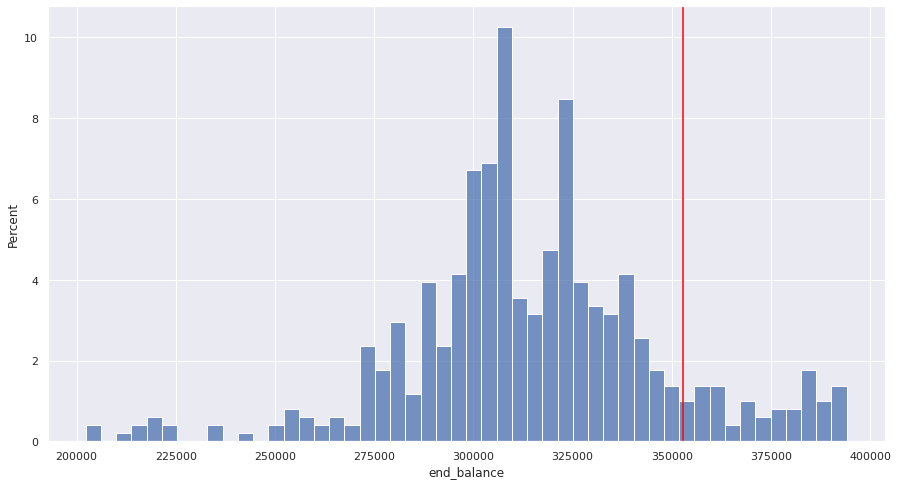

In [28]:
plot_hist(capped_scenarios, "end_balance");

Similarly, we can look at the distribution of maximum payments made over the whole 5 year term. As long as the cap at least covers your interest payments you never go over it, so unsurprisingly over 70% of the scenarios have a max payment equal to the fixed amount. Again though, there's a long tail (presumably corresponding to the massive rate hikes we saw in the late 70s and early 80s where you would end up making at least one payment that's more than double the fixed amount, ouch.

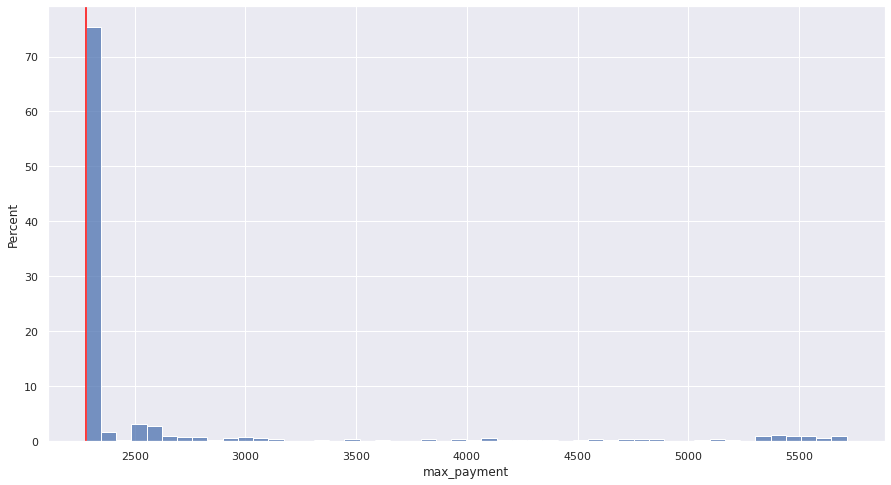

In [29]:
plot_hist(capped_scenarios, "max_payment");

Finally, let's look at the same scenarios, but just paying the variable rate the whole way through. The graphs represent the same things as above, just with the uncapped variable rate mortgage.

In [30]:
uncapped_scenarios = pd.DataFrame([
    Mortgage(
        delta_series=delta_df[col],
        scenario_name="1975-01-01 capped",
        capped_variable=False
    ).summarize()
    for col in delta_df.columns
])

/home/ipreston/miniconda3/envs/mortgage/lib/python3.10/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in double_scalars
  (1 + rate*when)*(temp - 1)/rate)
/home/ipreston/miniconda3/envs/mortgage/lib/python3.10/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in double_scalars
  (1 + rate*when)*(temp - 1)/rate)


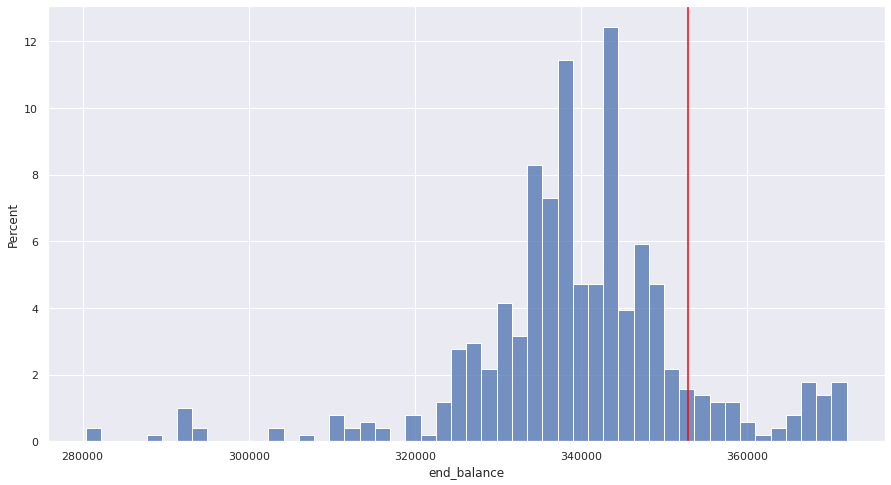

In [31]:
plot_hist(uncapped_scenarios, "end_balance");

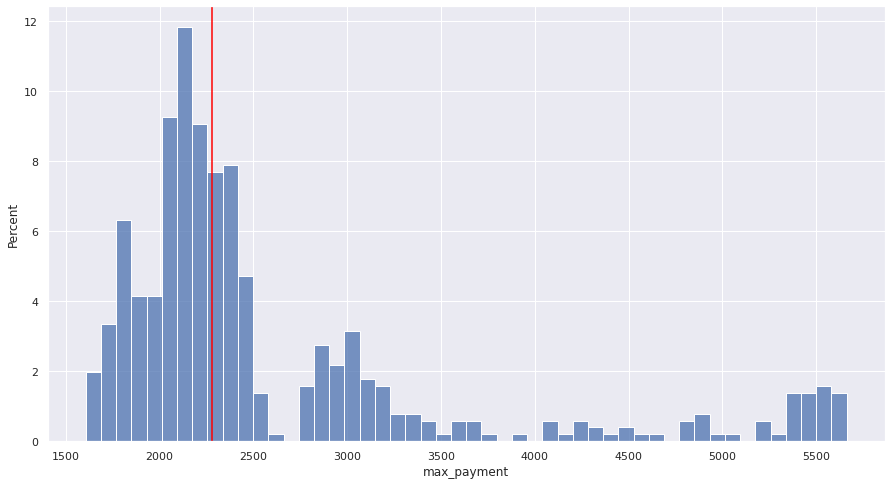

In [32]:
plot_hist(uncapped_scenarios, "max_payment");

The distribution of end balances looks reasonably similar, although the capped variable definitely has more weight on the lower end of the distribution, which is quite good. Unsurprisingly, the max payment is a much wider distribution than under the capped scenario, with a decent chunk of payments above what you'd do in the fixed rate scenario.

## Conclusion

I'm not sure I want to put a detailed conclusion here, that could sound like giving investment advice. Please keep in mind, that I'm not a mortgage/real estate/investment professional. I'm some guy on the internet who likes making charts and wants to buy a house soon. I found this process informative for my decision making, I think I'll leave it at that.